In [22]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [23]:
df = pd.read_csv('2023-2024_booking.csv')
df.drop('booking', axis=1, inplace=True)
df = df.drop_duplicates(subset=['ds'])
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')
df.head()

,ds,y
0,2023-01-01,0.5
1,2023-01-02,0.0
2,2023-01-03,0.0
3,2023-01-04,0.0
4,2023-01-05,0.0


In [24]:
def get_songkran_dates(year):
    return pd.date_range(f"{year}-04-13", f"{year}-04-15")

df["is_event"] = df["ds"].apply(lambda d: 1 if d in get_songkran_dates(d.year) else 0)

In [25]:
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

__Trend Model__

In [26]:
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])

21:36:22 - cmdstanpy - INFO - Chain [1] start processing
21:36:22 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend_yhat'] = trend_forecast['yhat'].values

__Trend Event Model__

In [28]:
event_model = Prophet()
event_model.add_regressor('is_event')
event_model.fit(train_df[['ds', 'y', 'is_event']])

event_forecast = event_model.predict(test_df[['ds', 'is_event']])
test_df['event_yhat'] = event_forecast['yhat'].values

21:36:22 - cmdstanpy - INFO - Chain [1] start processing
21:36:22 - cmdstanpy - INFO - Chain [1] done processing


In [29]:
def rule_based(row):
    if row['is_event'] == 1:
        return 0.5 * row['trend_yhat'] + 0.5 * row['event_yhat']
    else:
        return row['trend_yhat']

test_df['final_forecast'] = test_df.apply(rule_based, axis=1)

In [30]:
mae = mean_absolute_error(test_df['y'], test_df['final_forecast'])
mape = mean_absolute_percentage_error(test_df['y'], test_df['final_forecast'])

print(f"✅ MAE: {mae:.4f}")
print(f"✅ MAPE: {mape * 100:.2f}%")

✅ MAE: 0.1845
✅ MAPE: 57326428536835864.00%


In [31]:
nonzero_mask = test_df['y'] != 0
filtered_y_true = test_df.loc[nonzero_mask, 'y']
filtered_y_pred = test_df.loc[nonzero_mask, 'final_forecast']

In [32]:
mape = mean_absolute_percentage_error(filtered_y_true, filtered_y_pred)
print(f"✅ Clean MAPE: {mape * 100:.2f}%")

✅ Clean MAPE: 38.50%


In [33]:
import matplotlib.pyplot as plt

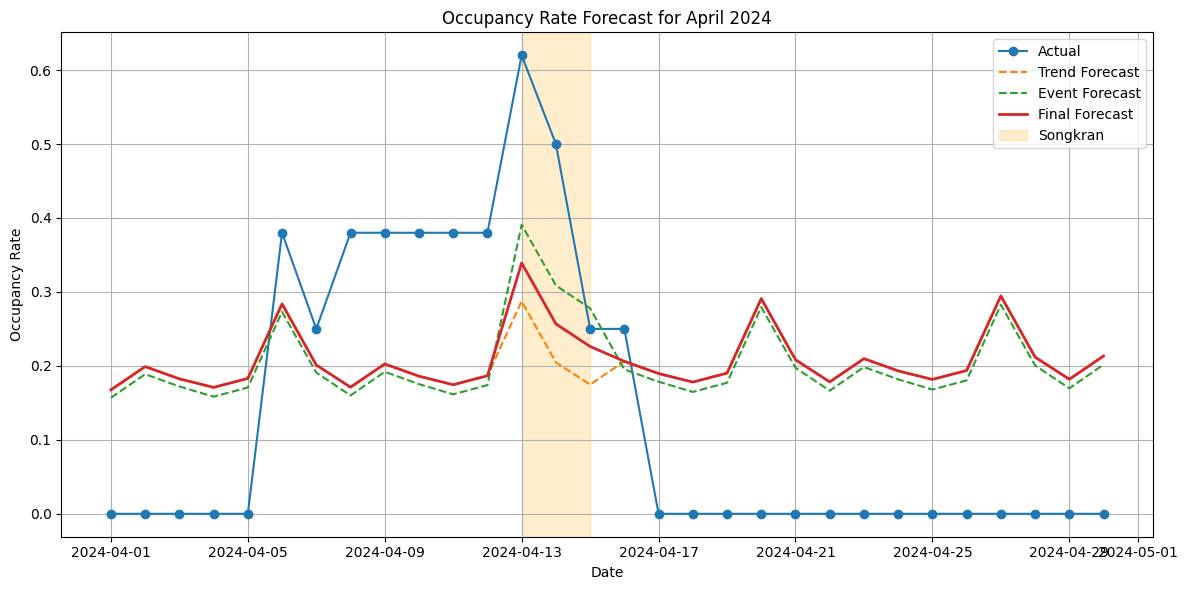

In [34]:
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend_yhat'], label='Trend Forecast', linestyle='--')
plt.plot(test_df['ds'], test_df['event_yhat'], label='Event Forecast', linestyle='--')
plt.plot(test_df['ds'], test_df['final_forecast'], label='Final Forecast', linewidth=2)
plt.axvspan(pd.to_datetime("2024-04-13"), pd.to_datetime("2024-04-15"), color='orange', alpha=0.2, label='Songkran')
plt.title('Occupancy Rate Forecast for April 2024')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

__Try new way__

In [36]:
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import holidays

In [37]:
df = pd.read_csv('2023-2024_booking.csv')
df.drop('booking', axis=1, inplace=True)
df = df.drop_duplicates(subset=['ds'])
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')
df.head()

,ds,y
0,2023-01-01,0.5
1,2023-01-02,0.0
2,2023-01-03,0.0
3,2023-01-04,0.0
4,2023-01-05,0.0


In [39]:
thai_holidays = holidays.Thailand(years=[2023, 2024])
df['is_holiday'] = df['ds'].apply(lambda x: 1 if x in thai_holidays else 0)
df['is_songkran'] = df['ds'].apply(lambda x: 1 if x.month == 4 and 13 <= x.day <= 15 else 0)
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_long_weekend'] = 0
for i in range(1, len(df) - 1):
    if df.iloc[i]['is_holiday'] == 1:
        if df.iloc[i - 1]['day_of_week'] == 4 or df.iloc[i + 1]['day_of_week'] == 0:
            df.iloc[i, df.columns.get_loc('is_long_weekend')] = 1

In [40]:
df['y_lag7'] = df['y'].shift(7)
df['y_lag7'].fillna(method='bfill', inplace=True)

/var/folders/_j/29xm46h90ng7h5ms1n444bmm0000gn/T/ipykernel_32626/97708276.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['y_lag7'].fillna(method='bfill', inplace=True)
/var/folders/_j/29xm46h90ng7h5ms1n444bmm0000gn/T/ipykernel_32626/97708276.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['y_lag7'].fillna(method='bfill', inplace=True)


In [41]:
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

__Trend Only__

In [42]:
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend'] = trend_forecast['yhat'].values

21:39:02 - cmdstanpy - INFO - Chain [1] start processing
21:39:02 - cmdstanpy - INFO - Chain [1] done processing


__Rule-Based Event Model__

In [43]:
def event_multiplier(row):
    multiplier = 1.0
    if row['is_holiday'] == 1:
        multiplier *= 1.05
    if row['is_songkran'] == 1:
        multiplier *= 1.15
    if row['is_long_weekend'] == 1:
        multiplier *= 1.10
    return multiplier

test_df['event_multiplier'] = test_df.apply(event_multiplier, axis=1)

In [48]:
# STEP 7: EVALUATE
# กรองข้อมูลที่ y ไม่เป็น 0
non_zero_df = test_df[test_df['y'] != 0]

# คำนวณ MAE และ MAPE ด้วย yhat_combined
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_combined'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_combined'])

print(f"✅ MAE (Filtered): {mae:.4f}")
print(f"✅ MAPE (Filtered): {mape * 100:.2f}%")


✅ MAE (Filtered): 0.1455
✅ MAPE (Filtered): 36.30%


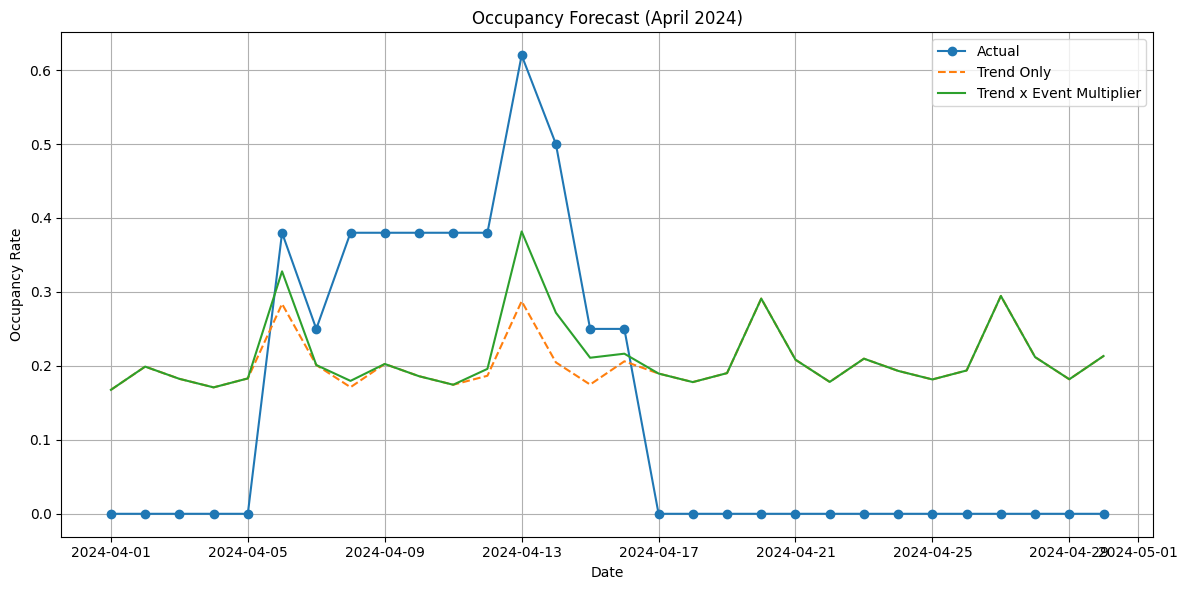

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Trend Only', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Event Multiplier', linestyle='-')
plt.title('Occupancy Forecast (April 2024)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

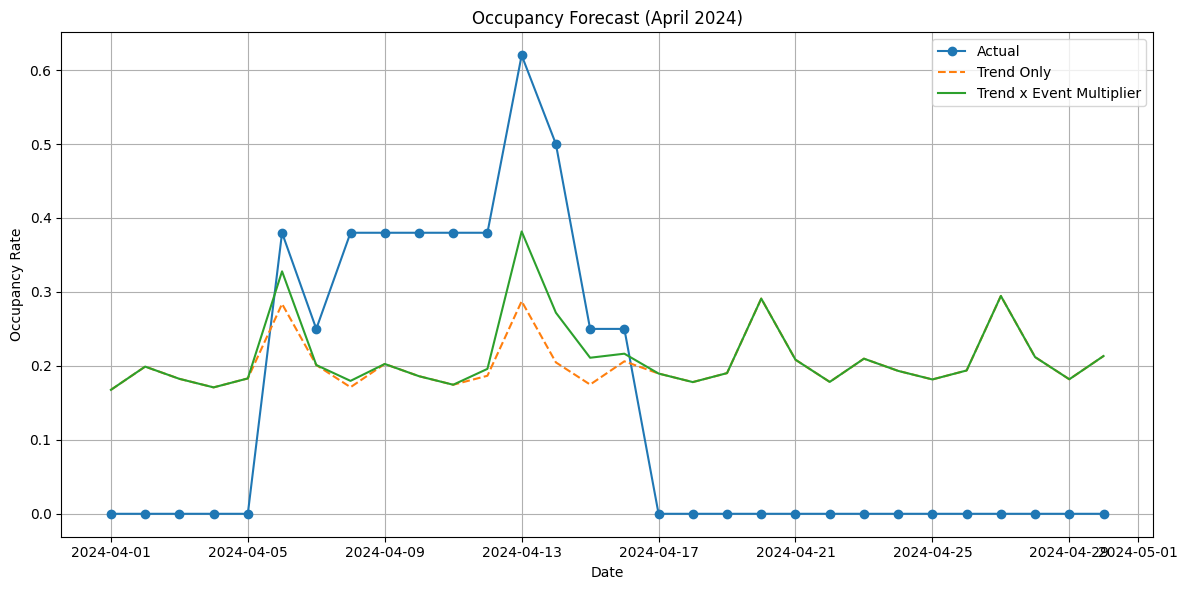

In [46]:
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Trend Only', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Event Multiplier', linestyle='-')
plt.title('Occupancy Forecast (April 2024)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import holidays

# STEP 2: LOAD DATA
df = pd.read_csv("occupancy_2023_2024.csv")
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['occupancy_rate']
df = df[['ds', 'y']]

# STEP 3: FEATURE ENGINEERING
thai_holidays = holidays.Thailand(years=[2023, 2024])
df['is_holiday'] = df['ds'].apply(lambda x: 1 if x in thai_holidays else 0)
df['is_songkran'] = df['ds'].apply(lambda x: 1 if x.month == 4 and 13 <= x.day <= 15 else 0)
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_long_weekend'] = 0
for i in range(1, len(df) - 1):
    if df.iloc[i]['is_holiday'] == 1:
        if df.iloc[i - 1]['day_of_week'] == 4 or df.iloc[i + 1]['day_of_week'] == 0:
            df.iloc[i, df.columns.get_loc('is_long_weekend')] = 1

# STEP 4: CREATE LAG FEATURE
df['y_lag7'] = df['y'].shift(7)
df['y_lag7'].fillna(method='bfill', inplace=True)

# STEP 5: FILTER APRIL 2024
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

# === MODEL 1: PROPHET (Trend Only) ===
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend'] = trend_forecast['yhat'].values

# === MODEL 2: Rule-Based Event Model ===
# สมมุติว่า holiday เพิ่ม +5%, songkran +15%, long weekend +10%
def event_multiplier(row):
    multiplier = 1.0
    if row['is_holiday'] == 1:
        multiplier *= 1.05
    if row['is_songkran'] == 1:
        multiplier *= 1.15
    if row['is_long_weekend'] == 1:
        multiplier *= 1.10
    return multiplier

test_df['event_multiplier'] = test_df.apply(event_multiplier, axis=1)

# STEP 6: COMBINE BOTH MODELS
test_df['yhat_combined'] = test_df['trend'] * test_df['event_multiplier']

# STEP 7: EVALUATE
mae = mean_absolute_error(test_df['y'], test_df['yhat_combined'])
mape = mean_absolute_percentage_error(test_df['y'], test_df['yhat_combined'])

print(f"✅ MAE (Combined): {mae:.4f}")
print(f"✅ MAPE (Combined): {mape * 100:.2f}%")

# STEP 8: PLOT
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Trend Only', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Event Multiplier', linestyle='-')
plt.title('Occupancy Forecast (April 2024)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


21:56:50 - cmdstanpy - INFO - Chain [1] start processing
21:56:50 - cmdstanpy - INFO - Chain [1] done processing


✅ MAE (Filtered): 0.1140
✅ MAPE (Filtered): 31.71%


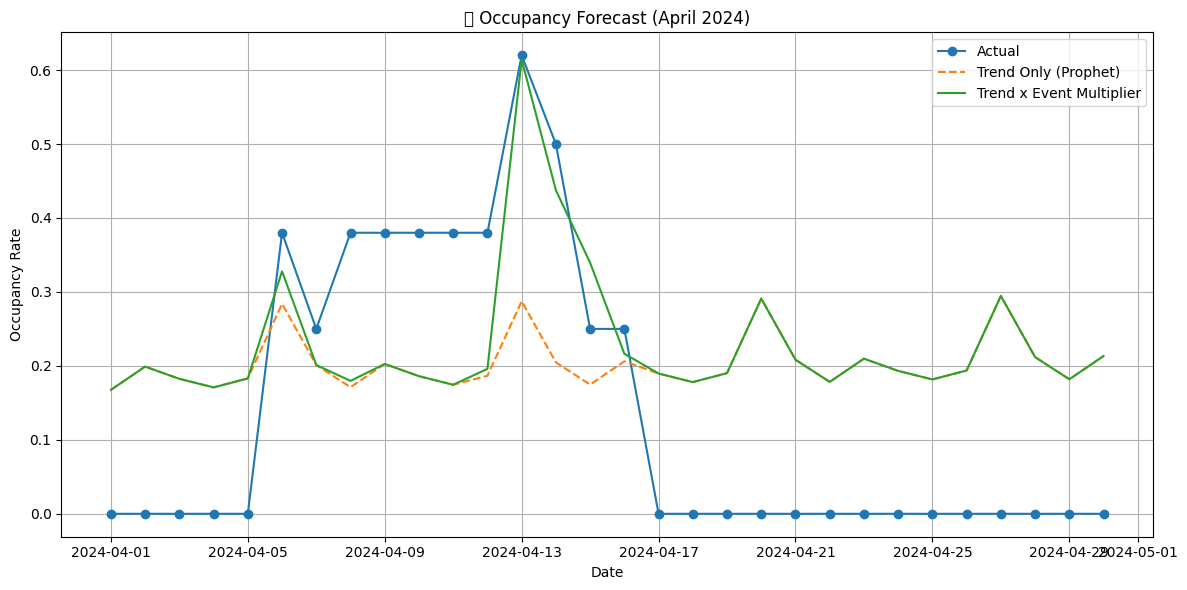

In [67]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import holidays
import warnings
warnings.filterwarnings("ignore")

# STEP 2: LOAD DATA
df = pd.read_csv('2023-2024_booking.csv')
df.drop('booking', axis=1, inplace=True)
df = df.drop_duplicates(subset=['ds'])
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# STEP 3: FEATURE ENGINEERING
thai_holidays = holidays.Thailand(years=[2023, 2024])
df['is_holiday'] = df['ds'].apply(lambda x: 1 if x in thai_holidays else 0)
df['is_songkran'] = df['ds'].apply(lambda x: 1 if x.month == 4 and 13 <= x.day <= 15 else 0)
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_long_weekend'] = 0

# หาวัน long weekend
for i in range(1, len(df) - 1):
    if df.iloc[i]['is_holiday'] == 1:
        if df.iloc[i - 1]['day_of_week'] == 4 or df.iloc[i + 1]['day_of_week'] == 0:
            df.iloc[i, df.columns.get_loc('is_long_weekend')] = 1

# STEP 4: LAG FEATURE
df['y_lag7'] = df['y'].shift(7)
df['y_lag7'].fillna(method='bfill', inplace=True)

# STEP 5: SPLIT TRAIN / TEST
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

# ============================
# MODEL 1: PROPHET (Trend Only)
# ============================
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend'] = trend_forecast['yhat'].values

# ============================
# MODEL 2: Rule-Based Multiplier
# ============================
# สมมุติว่า holiday +5%, songkran +15%, long weekend +10%
def event_multiplier(row):
    multiplier = 1.0
    if row['is_holiday'] == 1:
        multiplier *= 1.05
    if row['is_songkran'] == 1:
        multiplier *= 1.85
    if row['is_long_weekend'] == 1:
        multiplier *= 1.10
    return multiplier

test_df['event_multiplier'] = test_df.apply(event_multiplier, axis=1)

# ============================
# MODEL COMBINATION
# ============================
test_df['yhat_combined'] = test_df['trend'] * test_df['event_multiplier']

# ============================
# EVALUATION
# ============================
# mae = mean_absolute_error(test_df['y'], test_df['yhat_combined'])
# mape = mean_absolute_percentage_error(test_df['y'], test_df['yhat_combined'])

non_zero_df = test_df[test_df['y'] != 0]

# คำนวณ MAE และ MAPE ด้วย yhat_combined
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_combined'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_combined'])

print(f"✅ MAE (Filtered): {mae:.4f}")
print(f"✅ MAPE (Filtered): {mape * 100:.2f}%")

# print(f"✅ MAE (Combined): {mae:.4f}")
# print(f"✅ MAPE (Combined): {mape * 100:.2f}%")

# ============================
# PLOT RESULTS
# ============================
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Trend Only (Prophet)', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Event Multiplier', linestyle='-')
plt.title('📈 Occupancy Forecast (April 2024)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


KeyError: "['trend'] not in index"

22:01:15 - cmdstanpy - INFO - Chain [1] start processing
22:01:15 - cmdstanpy - INFO - Chain [1] done processing
22:01:15 - cmdstanpy - INFO - Chain [1] start processing
22:01:15 - cmdstanpy - INFO - Chain [1] done processing


✅ MAE (Hybrid): 0.2643
✅ MAPE (Hybrid): 68.87%


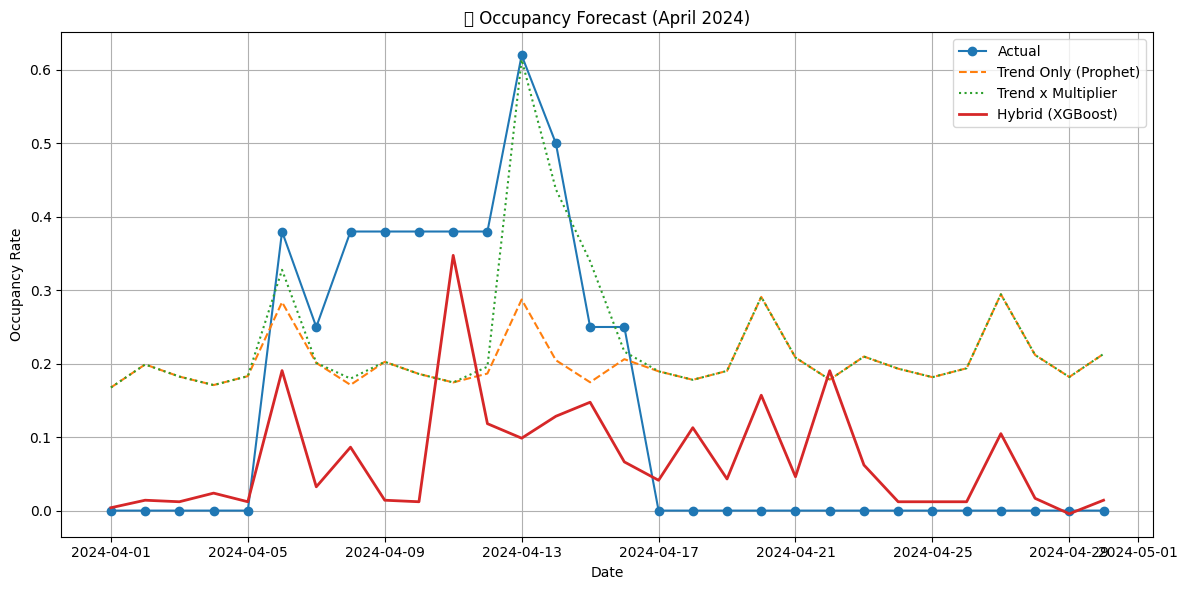

In [69]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import holidays
import warnings
warnings.filterwarnings("ignore")

# STEP 2: LOAD DATA
df = pd.read_csv('2023-2024_booking.csv')
df.drop('booking', axis=1, inplace=True)
df = df.drop_duplicates(subset=['ds'])
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# STEP 3: FEATURE ENGINEERING
thai_holidays = holidays.Thailand(years=[2023, 2024])
df['is_holiday'] = df['ds'].apply(lambda x: 1 if x in thai_holidays else 0)
df['is_songkran'] = df['ds'].apply(lambda x: 1 if x.month == 4 and 13 <= x.day <= 15 else 0)
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_long_weekend'] = 0

# หาวัน long weekend
for i in range(1, len(df) - 1):
    if df.iloc[i]['is_holiday'] == 1:
        if df.iloc[i - 1]['day_of_week'] == 4 or df.iloc[i + 1]['day_of_week'] == 0:
            df.iloc[i, df.columns.get_loc('is_long_weekend')] = 1

# STEP 4: LAG FEATURE
df['y_lag7'] = df['y'].shift(7)
df['y_lag7'].fillna(method='bfill', inplace=True)

# STEP 5: SPLIT TRAIN / TEST
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

# ============================
# MODEL 1: PROPHET (Trend Only)
# ============================
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend'] = trend_forecast['yhat'].values

# ============================
# MODEL 2: Rule-Based Multiplier
# ============================
def event_multiplier(row):
    multiplier = 1.0
    if row['is_holiday'] == 1:
        multiplier *= 1.05
    if row['is_songkran'] == 1:
        multiplier *= 1.85
    if row['is_long_weekend'] == 1:
        multiplier *= 1.10
    return multiplier

test_df['event_multiplier'] = test_df.apply(event_multiplier, axis=1)
test_df['yhat_combined'] = test_df['trend'] * test_df['event_multiplier']

# ============================
# MODEL 3: XGBoost Hybrid
# ============================
# เตรียม features
train_df['trend'] = Prophet().fit(train_df[['ds', 'y']]).predict(train_df[['ds']])['yhat']
train_df['event_multiplier'] = train_df.apply(event_multiplier, axis=1)
train_df['yhat_combined'] = train_df['trend'] * train_df['event_multiplier']

# Features & Target
features = ['trend', 'event_multiplier', 'day_of_week', 'y_lag7', 'is_holiday', 'is_songkran', 'is_long_weekend']
X_train = train_df[features]
y_train = train_df['y']
X_test = test_df[features]
y_test = test_df['y']

# Fit XGBoost
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict
test_df['yhat_hybrid'] = xgb_model.predict(X_test)

# ============================
# EVALUATION
# ============================
non_zero_df = test_df[test_df['y'] != 0]

mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])

print(f"✅ MAE (Hybrid): {mae:.4f}")
print(f"✅ MAPE (Hybrid): {mape * 100:.2f}%")

# ============================
# PLOT RESULTS
# ============================
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Trend Only (Prophet)', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Multiplier', linestyle=':')
plt.plot(test_df['ds'], test_df['yhat_hybrid'], label='Hybrid (XGBoost)', linewidth=2)
plt.title('📈 Occupancy Forecast (April 2024)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


22:26:10 - cmdstanpy - INFO - Chain [1] start processing
22:26:10 - cmdstanpy - INFO - Chain [1] done processing


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 365, number of used features: 9
[LightGBM] [Info] Start training from score 0.089644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -in

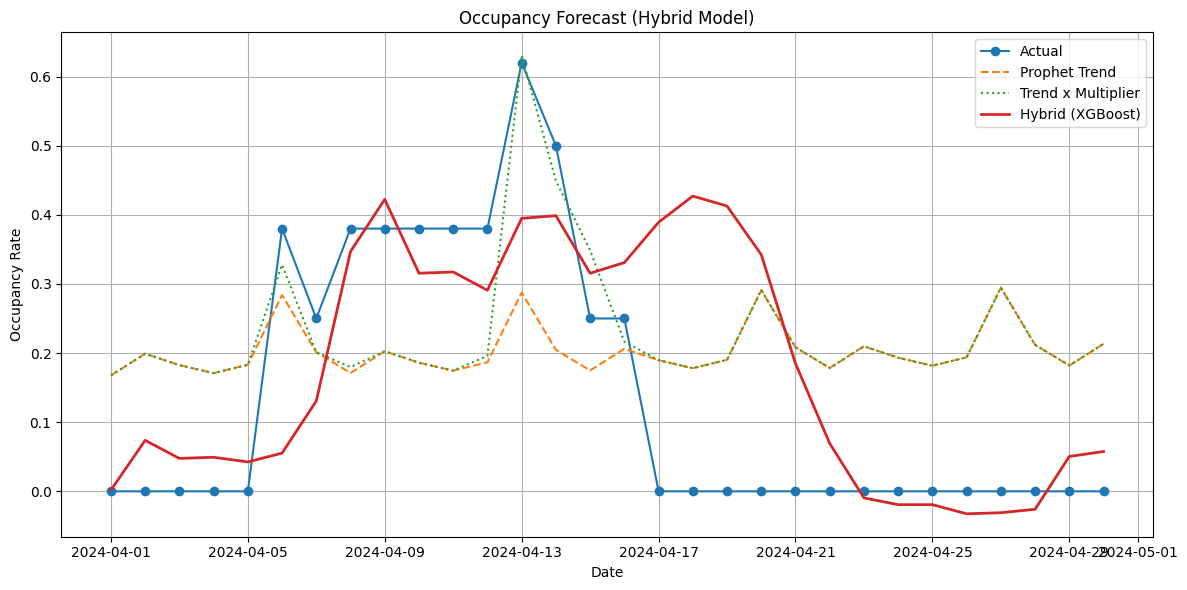

In [103]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import holidays
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# STEP 2: LOAD DATA
df = pd.read_csv('2023-2024_booking.csv')
df.drop('booking', axis=1, inplace=True)
df = df.drop_duplicates(subset=['ds'])
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# STEP 3: FEATURE ENGINEERING
thai_holidays = holidays.Thailand(years=[2023, 2024])
df['is_holiday'] = df['ds'].apply(lambda x: 1 if x in thai_holidays else 0)
df['is_songkran'] = df['ds'].apply(lambda x: 1 if x.month == 4 and 13 <= x.day <= 15 else 0)
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_long_weekend'] = 0

# หาวัน long weekend
for i in range(1, len(df) - 1):
    if df.iloc[i]['is_holiday'] == 1:
        if df.iloc[i - 1]['day_of_week'] == 4 or df.iloc[i + 1]['day_of_week'] == 0:
            df.iloc[i, df.columns.get_loc('is_long_weekend')] = 1

# Lag Features
df['y_lag7'] = df['y'].shift(7)
df['y_lag14'] = df['y'].shift(14)

# Rolling Mean
df['rolling_mean_7'] = df['y'].rolling(window=7).mean()
df['rolling_std_7'] = df['y'].rolling(window=7).std()

# Fill missing with backfill
df.fillna(method='bfill', inplace=True)

# STEP 4: TRAIN/TEST SPLIT
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

# STEP 5: PROPHET TREND MODEL
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend'] = trend_forecast['yhat'].values

# STEP 6: EVENT MULTIPLIER
def event_multiplier(row):
    multiplier = 1.0
    if row['is_holiday'] == 1:
        multiplier *= 1.05
    if row['is_songkran'] == 1:
        multiplier *= 1.90
    if row['is_long_weekend'] == 1:
        multiplier *= 1.10
    return multiplier

test_df['event_multiplier'] = test_df.apply(event_multiplier, axis=1)
test_df['yhat_combined'] = test_df['trend'] * test_df['event_multiplier']

# STEP 6.5: Add trend + event_multiplier ให้กับ train_df
trend_forecast_train = trend_model.predict(train_df[['ds']])
train_df['trend'] = trend_forecast_train['yhat'].values
train_df['event_multiplier'] = train_df.apply(event_multiplier, axis=1)

# STEP 7: HYBRID MODEL (XGBoost)
features = ['trend', 'event_multiplier', 'day_of_week', 'is_weekend',
            'is_holiday', 'is_songkran', 'is_long_weekend',
            'y_lag7', 'y_lag14', 'rolling_mean_7', 'rolling_std_7']

x_train = train_df[features]
y_train = train_df['y']
x_test = test_df[features]


# ✅ ปรับ Hyperparameters
# xgb_model = XGBRegressor(
#     objective='reg:squarederror',
#     max_depth=3,
#     learning_rate=0.1,
#     n_estimators=200,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )
# xgb_model.fit(x_train, y_train)

# # พยากรณ์ Hybrid
# test_df['yhat_hybrid'] = xgb_model.predict(x_test)

lgbm_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_model.fit(x_train, y_train)
test_df['yhat_hybrid'] = lgbm_model.predict(x_test)

# STEP 8: EVALUATION
non_zero_df = test_df[test_df['y'] != 0]
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])

print(f"✅ MAE (Hybrid): {mae:.4f}")
print(f"✅ MAPE (Hybrid): {mape * 100:.2f}%")

# STEP 9: PLOT RESULTS
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Prophet Trend', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Multiplier', linestyle=':')
plt.plot(test_df['ds'], test_df['yhat_hybrid'], label='Hybrid (XGBoost)', linewidth=2)
plt.title('Occupancy Forecast (Hybrid Model)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


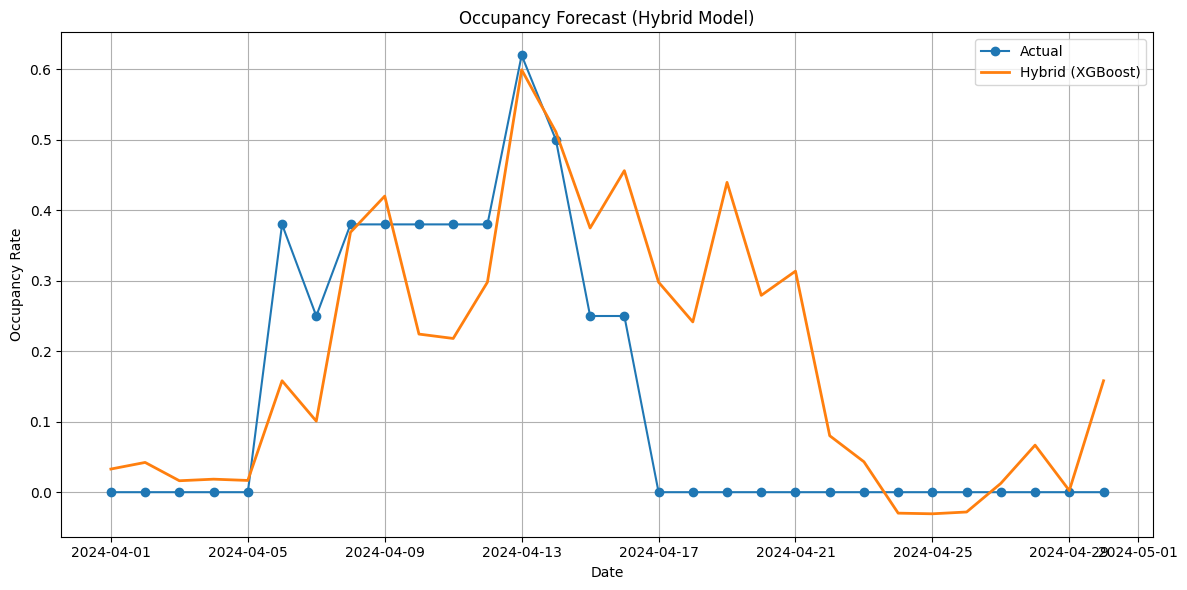

In [75]:
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
# plt.plot(test_df['ds'], test_df['trend'], label='Prophet Trend', linestyle='--')
# plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Multiplier', linestyle=':')
plt.plot(test_df['ds'], test_df['yhat_hybrid'], label='Hybrid (XGBoost)', linewidth=2)
plt.title('Occupancy Forecast (Hybrid Model)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [76]:
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    cv=3,
    scoring='neg_mean_absolute_percentage_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(x_train, y_train)
print("✅ Best Parameters:", grid_search.best_params_)

Fitting 3 folds for each of 243 candidates, totalling 729 fits
✅ Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}


In [77]:
best_model = grid_search.best_estimator_
test_df['yhat_hybrid'] = best_model.predict(x_test)

non_zero_df = test_df[test_df['y'] != 0]
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])

print(f"✅ MAE (Hybrid): {mae:.4f}")
print(f"✅ MAPE (Hybrid): {mape * 100:.2f}%")

✅ MAE (Hybrid): 0.1169
✅ MAPE (Hybrid): 32.34%


In [79]:
%pip install lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 2.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [101]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_model.fit(x_train, y_train)
test_df['yhat_hybrid'] = lgbm_model.predict(x_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 244
[LightGBM] [Info] Number of data points in the train set: 365, number of used features: 9
[LightGBM] [Info] Start training from score 0.089644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [102]:
non_zero_df = test_df[test_df['y'] != 0]
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])

print(f"✅ MAE (Hybrid): {mae:.4f}")
print(f"✅ MAPE (Hybrid): {mape * 100:.2f}%")

✅ MAE (Hybrid): 0.1099
✅ MAPE (Hybrid): 29.56%


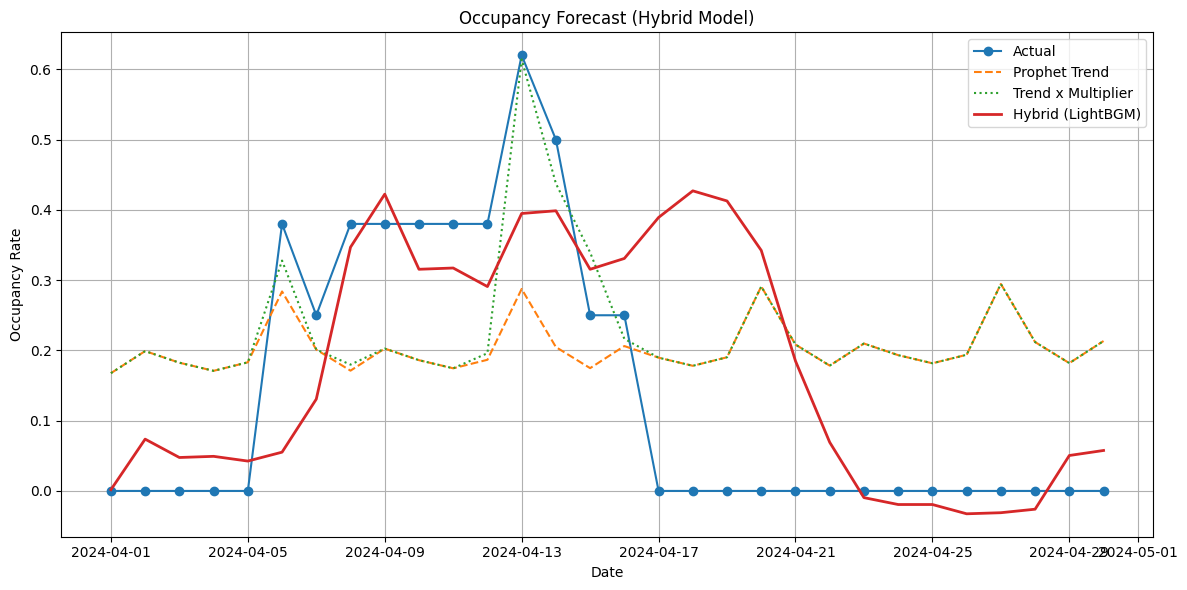

In [96]:
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Prophet Trend', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Multiplier', linestyle=':')
plt.plot(test_df['ds'], test_df['yhat_hybrid'], label='Hybrid (LightBGM)', linewidth=2)
plt.title('Occupancy Forecast (Hybrid Model)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# STEP 1: IMPORT LIBRARIES
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt
import holidays
import warnings
warnings.filterwarnings("ignore")

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# STEP 2: LOAD DATA
df = pd.read_csv('2023-2024_booking.csv')
df.drop('booking', axis=1, inplace=True)
df = df.drop_duplicates(subset=['ds'])
df['ds'] = pd.to_datetime(df['ds'], format='%d/%m/%Y')

# STEP 3: FEATURE ENGINEERING
thai_holidays = holidays.Thailand(years=[2023, 2024])
df['is_holiday'] = df['ds'].apply(lambda x: 1 if x in thai_holidays else 0)
df['is_songkran'] = df['ds'].apply(lambda x: 1 if x.month == 4 and 13 <= x.day <= 15 else 0)
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
df['is_long_weekend'] = 0

# หาวัน long weekend
for i in range(1, len(df) - 1):
    if df.iloc[i]['is_holiday'] == 1:
        if df.iloc[i - 1]['day_of_week'] == 4 or df.iloc[i + 1]['day_of_week'] == 0:
            df.iloc[i, df.columns.get_loc('is_long_weekend')] = 1

# Lag Features
df['y_lag7'] = df['y'].shift(7)
df['y_lag14'] = df['y'].shift(14)

# Rolling Mean
df['rolling_mean_7'] = df['y'].rolling(window=7).mean()
df['rolling_std_7'] = df['y'].rolling(window=7).std()

# Fill missing with backfill
df.fillna(method='bfill', inplace=True)

# STEP 4: TRAIN/TEST SPLIT
train_df = df[df['ds'] < '2024-01-01'].copy()
test_df = df[(df['ds'] >= '2024-04-01') & (df['ds'] <= '2024-04-30')].copy()

# STEP 5: PROPHET TREND MODEL
trend_model = Prophet()
trend_model.fit(train_df[['ds', 'y']])
trend_forecast = trend_model.predict(test_df[['ds']])
test_df['trend'] = trend_forecast['yhat'].values

# STEP 6: EVENT MULTIPLIER
def event_multiplier(row):
    multiplier = 1.0
    if row['is_holiday'] == 1:
        multiplier *= 1.05
    if row['is_songkran'] == 1:
        multiplier *= 1.90
    if row['is_long_weekend'] == 1:
        multiplier *= 1.10
    return multiplier

test_df['event_multiplier'] = test_df.apply(event_multiplier, axis=1)
test_df['yhat_combined'] = test_df['trend'] * test_df['event_multiplier']

# STEP 6.5: Add trend + event_multiplier ให้กับ train_df
trend_forecast_train = trend_model.predict(train_df[['ds']])
train_df['trend'] = trend_forecast_train['yhat'].values
train_df['event_multiplier'] = train_df.apply(event_multiplier, axis=1)

# STEP 7: HYBRID MODEL (XGBoost)
features = ['trend', 'event_multiplier', 'day_of_week', 'is_weekend',
            'is_holiday', 'is_songkran', 'is_long_weekend',
            'y_lag7', 'y_lag14', 'rolling_mean_7', 'rolling_std_7']

x_train = train_df[features]
y_train = train_df['y']
x_test = test_df[features]


lgbm_model = LGBMRegressor(
    objective='regression',
    learning_rate=0.05,
    n_estimators=200,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_model.fit(x_train, y_train)
test_df['yhat_hybrid'] = lgbm_model.predict(x_test)

# STEP 8: EVALUATION
non_zero_df = test_df[test_df['y'] != 0]
mae = mean_absolute_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])
mape = mean_absolute_percentage_error(non_zero_df['y'], non_zero_df['yhat_hybrid'])

print(f"✅ MAE (Hybrid): {mae:.4f}")
print(f"✅ MAPE (Hybrid): {mape * 100:.2f}%")

# STEP 9: PLOT RESULTS
plt.figure(figsize=(12,6))
plt.plot(test_df['ds'], test_df['y'], label='Actual', marker='o')
plt.plot(test_df['ds'], test_df['trend'], label='Prophet Trend', linestyle='--')
plt.plot(test_df['ds'], test_df['yhat_combined'], label='Trend x Multiplier', linestyle=':')
plt.plot(test_df['ds'], test_df['yhat_hybrid'], label='Hybrid (XGBoost)', linewidth=2)
plt.title('Occupancy Forecast (Hybrid Model)')
plt.xlabel("Date")
plt.ylabel("Occupancy Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
